In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout # adding layers to the Neural Network model
from tensorflow import keras # for building Neural Networks
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization

from sklearn.preprocessing import MinMaxScaler # for scaling inputs used in the generator and discriminator

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
import time
import PIL
from IPython import display

def get_training_data(image_path):
    """Loads an image from the given path into a numpy array."""
    with Image.open(image_path) as img:
        return np.array(img)

# Actual project

In [ ]:
def extract_frame(video_path, time_in_seconds):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video file.")
        return None

    # Get the frame rate of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate the frame number to be captured
    frame_number = int(time_in_seconds * fps)

    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()

    # Release the video capture object
    cap.release()

    if ret:
        return frame  # Return the frame if successfully captured
    else:
        print("Error: Could not retrieve frame at given time.")
        return None

### Extracting data

In [ ]:
def convert_combine(arrays):
    grayscaled = [np.mean(array, axis=2, keepdims=True) for array in arrays]
    combined = np.stack(grayscaled, axis=0)

    # list of all the frames

    return combined
    # extract_frame('./mTBI/video_sequence/00029_U_4_19_2018_9_18_9_V001.avi', 1).shape

def avi_parser(avi_file="./mTBI/video_sequence/00029_U_4_19_2018_9_18_9_V001.avi"):
    temp = []

    # avi_file = "00029_U_4_19_2018_9_18_9_V001.avi"
    # Open the video file
    cap = cv2.VideoCapture(avi_file)

    # Check if the video file opened successfully
    if not cap.isOpened():
        print("Error: Could not open video file.")
    else:
        # Loop through each frame
        while True:
            ret, frame = cap.read()
            if not ret:
                break  # Break the loop if there are no frames left

            # Process the frame here
            # For example, you can display the frame using cv2.imshow("Frame", frame)
            # print(type(frame))
            temp.append(frame)

    # Release the video capture object
    cap.release()
    cv2.destroyAllWindows()
    return temp

In [ ]:
avi_obj = avi_parser("00233_U_9_6_2018_13_12_13_V001.avi")
# avi_obj = avi_parser("./mTBI/video_sequence/00233_U_9_27_2018_14_52_33_V001.avi")
# print(np.array(temp).shape)

In [ ]:
# temp = avi_parser("./mTBI/video_sequence/00152_U_5_16_2018_8_49_17_V001.avi")
# # print(np.array(temp).shape)
# avi_obj += temp

In [ ]:
# temp = avi_parser("./mTBI/video_sequence/00029_U_4_19_2018_9_18_9_V001.avi")
# # print(np.array(temp).shape)
# avi_obj += temp

In [ ]:
print(np.array(avi_obj).shape)

(300, 512, 512, 3)


In [ ]:
avi_train = convert_combine(avi_obj)
type(avi_train)

numpy.ndarray

In [ ]:
def shape_finder(csv_directory= './mTBI/eye_motion_trace'):
    # Directory containing CSV files
    csv_directory = './mTBI/eye_motion_trace'

    # Loop through each file in the directory
    for filename in os.listdir(csv_directory):
        if filename.endswith('.csv'):
            # Construct the full file path
            file_path = os.path.join(csv_directory, filename)

            # Read the CSV file into a DataFrame
            temp = pd.read_csv(file_path)

            # Print the filename and shape of the DataFrame
            print(f"File: {filename}, Shape: {temp.shape[0]}")

In [ ]:
avi_train = avi_train.reshape(avi_train.shape[0], 512, 512, 1).astype('float32')
avi_train_images = (avi_train - 127.5) / 127.5  # Normalize the images to [-1, 1]
avi_train_images.shape

(300, 512, 512, 1)

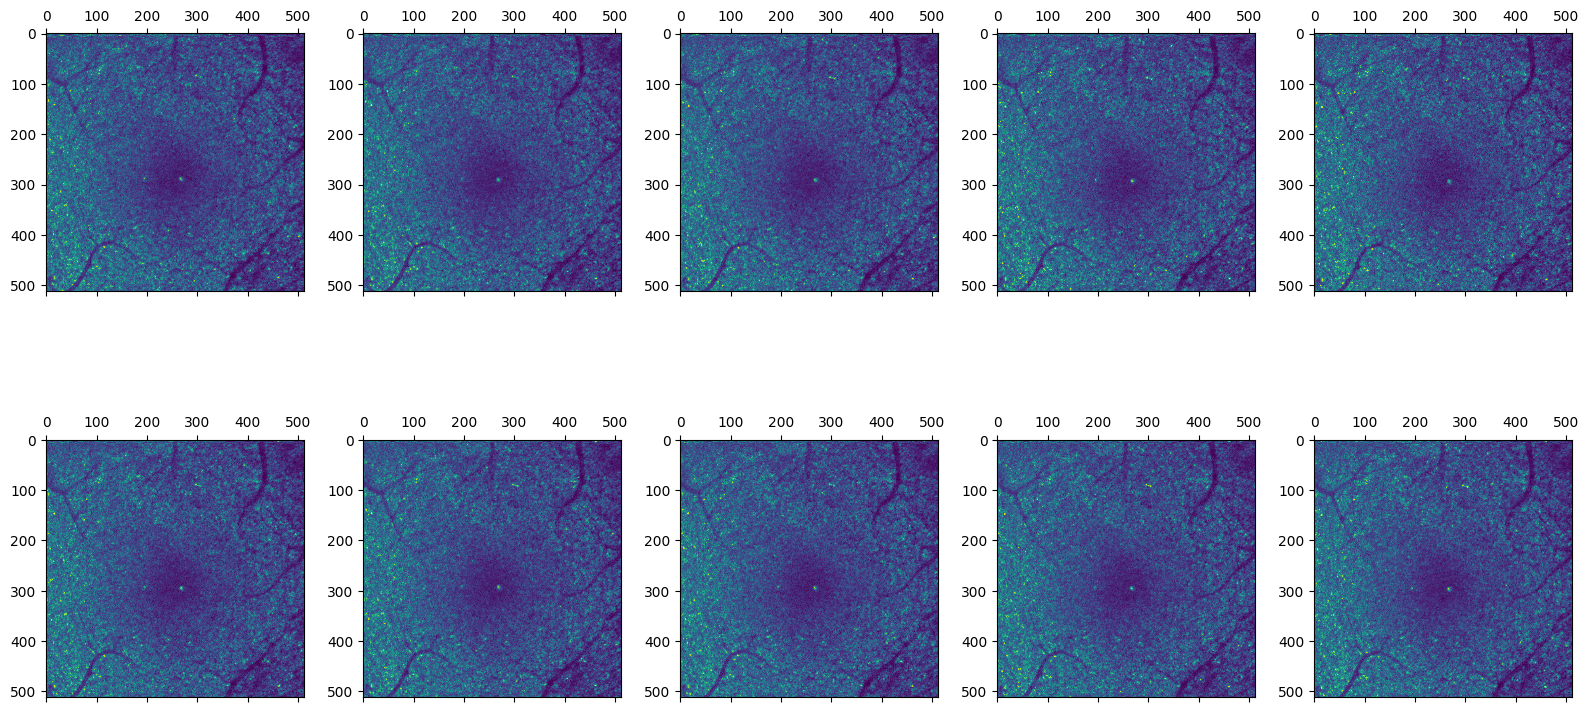

In [ ]:
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(avi_train_images[n + 200])
        n=n+1
plt.show()

In [ ]:
# We don't have the computational power to process 300 512x512 images
def downscale_image(image):
    # Assuming image is a numpy array of shape (512, 512, 1)
    # Resize the image to 64x64
    downscaled_image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
    return downscaled_image

temp = []
for i in range(len(avi_train_images)):
    if i % 2 != 0:
        continue
    temp.append(downscale_image(avi_train_images[i]))

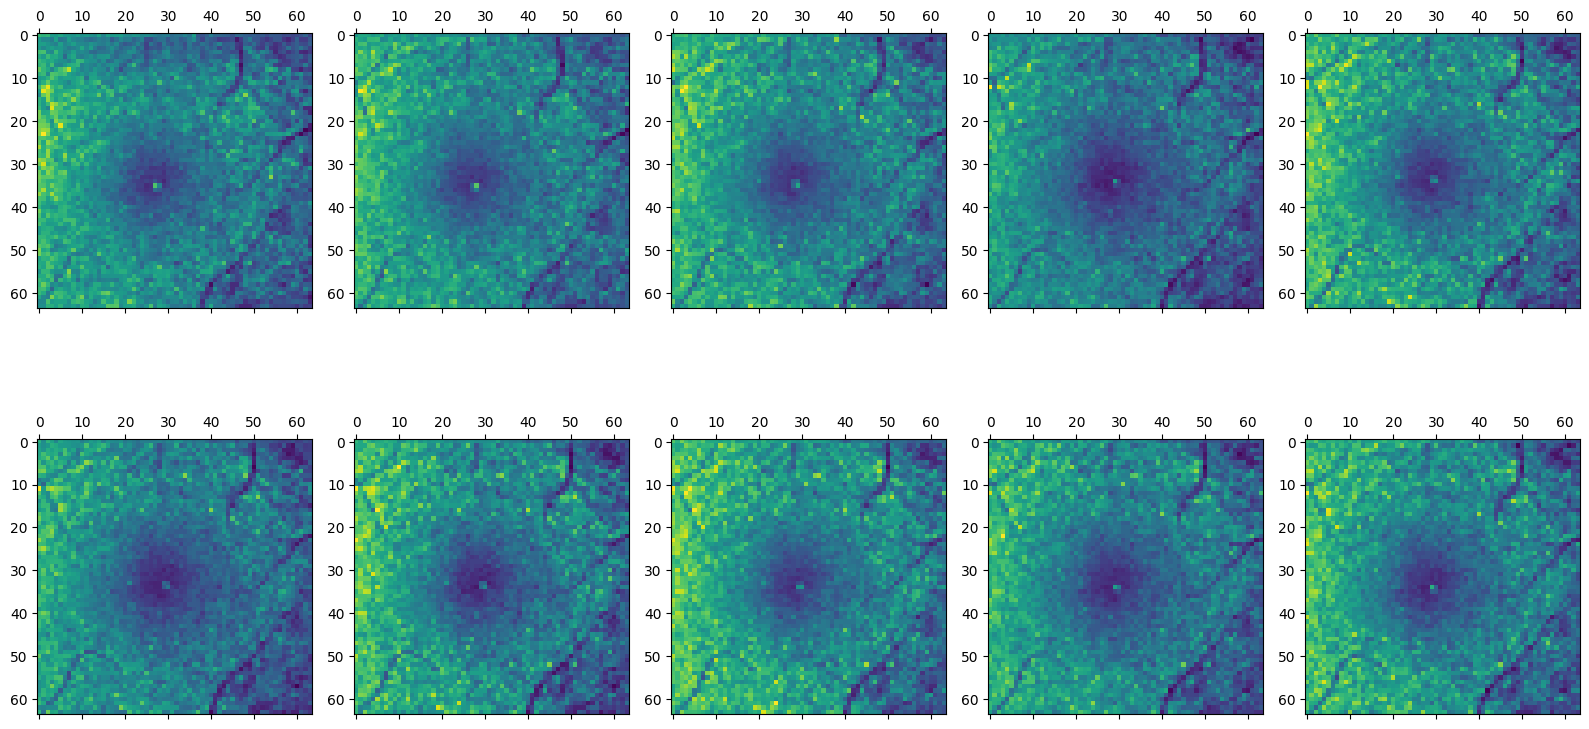

In [ ]:
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(temp[n])
        n=n+1
plt.show()

In [ ]:
avi_train_images = np.array(temp)

In [ ]:
# Scaler
scaler=MinMaxScaler(feature_range=(-1, 1))

# Select images that we want to use fro model trainng
data=avi_train_images.copy()
print("Original shape of the data: ", data.shape)

# Reshape array
data=data.reshape(-1, 1)
print("Reshaped data: ", data.shape)

# Fit the scaler
scaler.fit(data)

# Scale the array
data=scaler.transform(data)

# Reshape back to the original shape
data=data.reshape(avi_train_images.shape[0], 64, 64, 1)
print("Shape of the scaled array: ", data.shape)

Original shape of the data:  (150, 64, 64)
Reshaped data:  (614400, 1)
Shape of the scaled array:  (150, 64, 64, 1)


# Side quest

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
data_set = tf.data.Dataset.from_tensor_slices(avi_train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def generator(latent_dim):
    model = Sequential(name="Generator") # Model

    # Hidden Layer 1: Start with 8 x 8 image
    n_nodes = 8 * 8 * 128 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_dim=latent_dim, name='Generator-Hidden-Layer-1'))
    model.add(Reshape((8, 8, 128), name='Generator-Hidden-Layer-Reshape-1'))

    # Hidden Layer 2: Upsample to 16 x 16
    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-2'))

    # Hidden Layer 3: Upsample to 32 x 32
    model.add(Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-3'))

    # Hidden Layer 4: Upsample to 64 x 64
    model.add(Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-4'))

    model.add(Conv2D(filters=1, kernel_size=(5,5), activation='tanh', padding='same', name='Generator-Output-Layer'))
    return model

# Instantiate
latent_dim=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)
# plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=400)

In [ ]:
def discriminator(in_shape=(64,64,1)):
    model = Sequential(name="Discriminator") # Model

    # Hidden Layer 1
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))

    # Hidden Layer 2
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))

    # Hidden Layer 3
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))

    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
# plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400)

In [ ]:
def def_gan(generator, discriminator):

    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False

    # Combine
    model = Sequential(name="DCGAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Disriminator

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

In [ ]:
gan_model.summary()


In [ ]:
def real_samples(n, dataset):

    # Samples of real data
    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))
    return X, y


def latent_vector(latent_dim, n):

    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)

    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input


def fake_samples(generator, latent_dim, n):

    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)

    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)

    # Create class labels
    y = np.zeros((n, 1))
    return X, y

In [ ]:
def performance_summary(generator, discriminator, dataset, latent_dim, n=50):

    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)

    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)

    # summarize discriminator performance
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)

    # Display 6 fake images
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 1)

    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,3):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show()

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1001, n_batch=32, n_eval=100):

    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)

    # We will manually enumare epochs
    for i in range(n_epochs):

    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)

        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)

    # Generator training
        # Get values from the latent space to be used as inputs for the generator
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples,
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))

        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)

        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim)

In [ ]:
tf.keras.utils.disable_interactive_logging()

Epoch number:  0
*** Training ***
Discriminator Loss  0.6884509921073914
Generator Loss:  0.6935851573944092
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.0


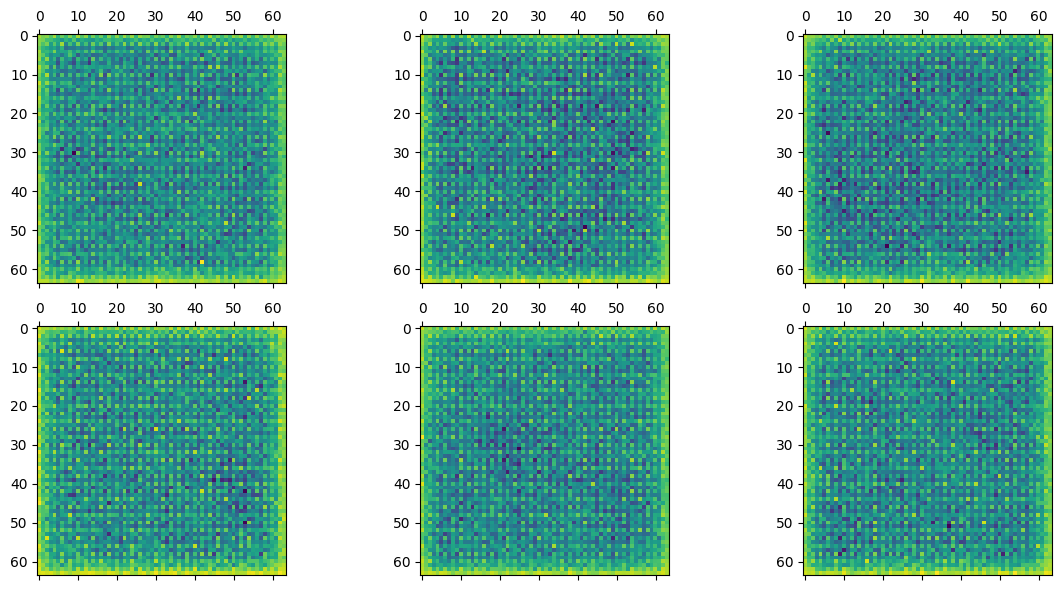

Epoch number:  100
*** Training ***
Discriminator Loss  0.7662197351455688
Generator Loss:  1.2249805927276611
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.0
Discriminator Accuracy on FAKE (generated) images:  1.0


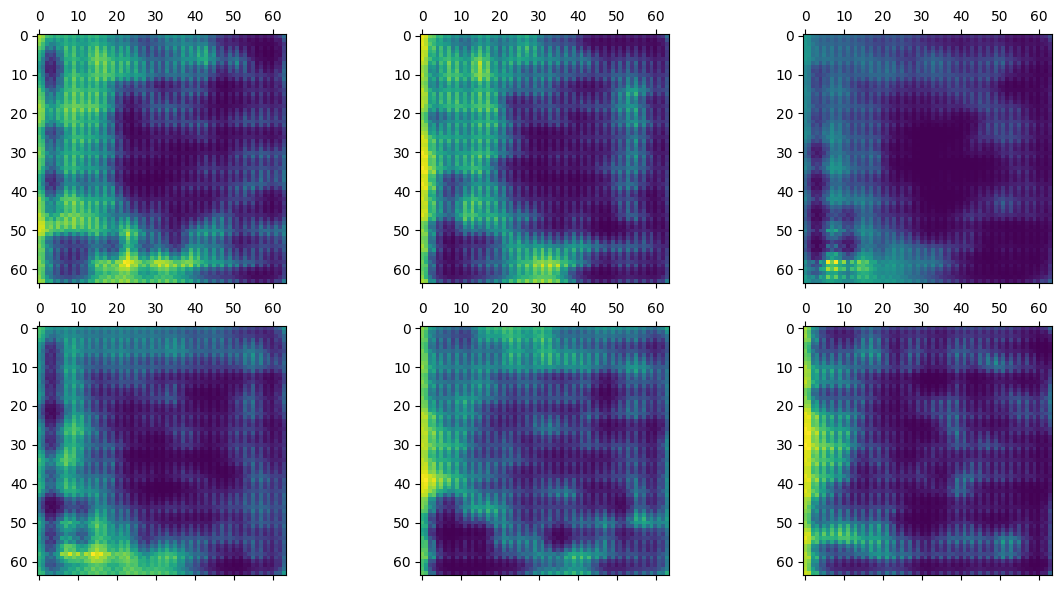

Epoch number:  200
*** Training ***
Discriminator Loss  0.7338639497756958
Generator Loss:  0.9381939172744751
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7200000286102295
Discriminator Accuracy on FAKE (generated) images:  0.7599999904632568


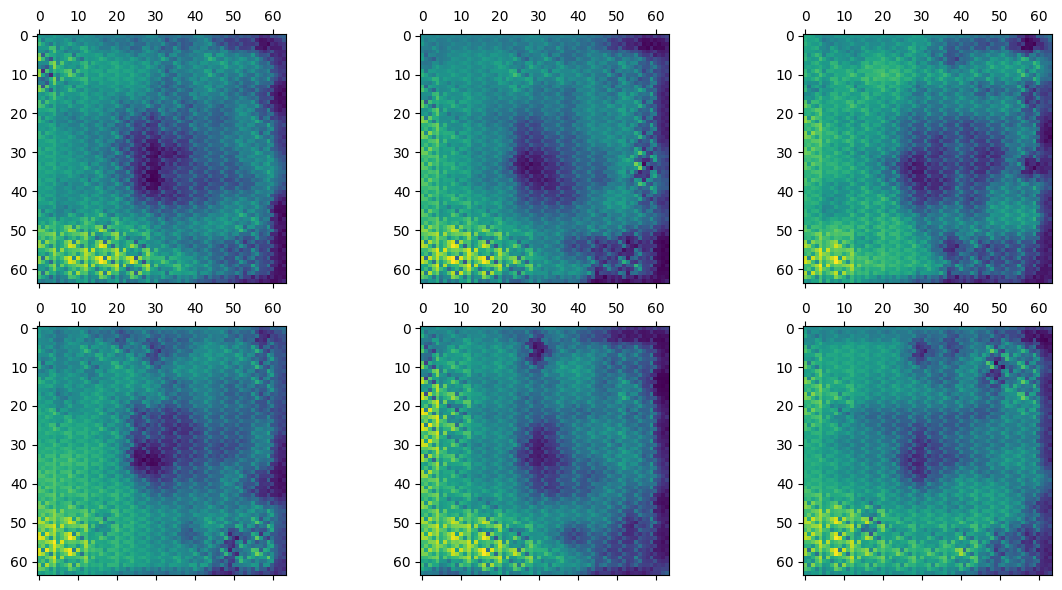

Epoch number:  300
*** Training ***
Discriminator Loss  0.5677051544189453
Generator Loss:  0.904131293296814
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8799999952316284
Discriminator Accuracy on FAKE (generated) images:  0.8600000143051147


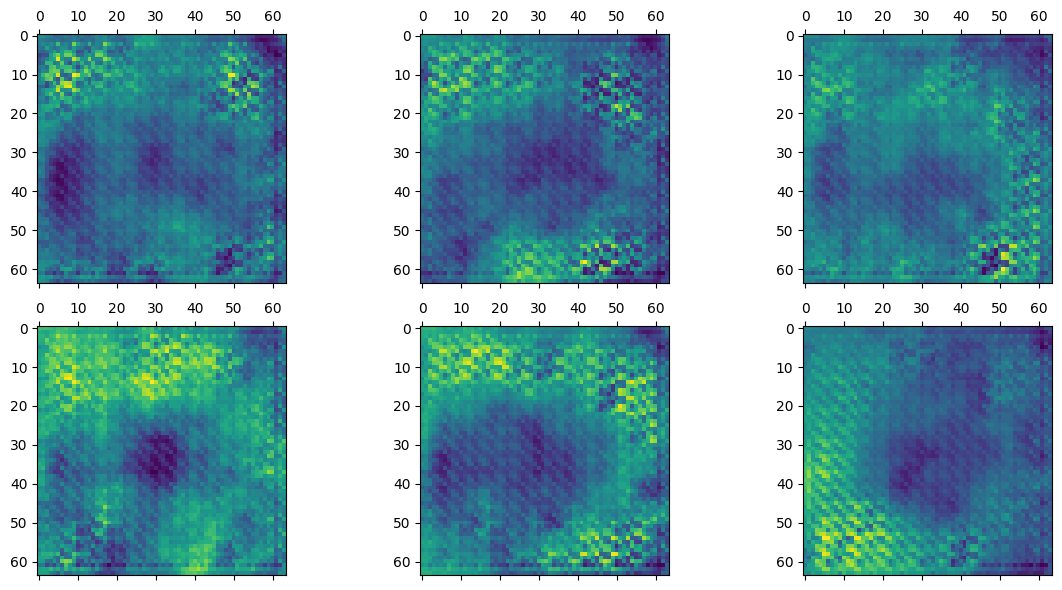

Epoch number:  400
*** Training ***
Discriminator Loss  0.6497858762741089
Generator Loss:  0.8109217882156372
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6000000238418579
Discriminator Accuracy on FAKE (generated) images:  0.8799999952316284


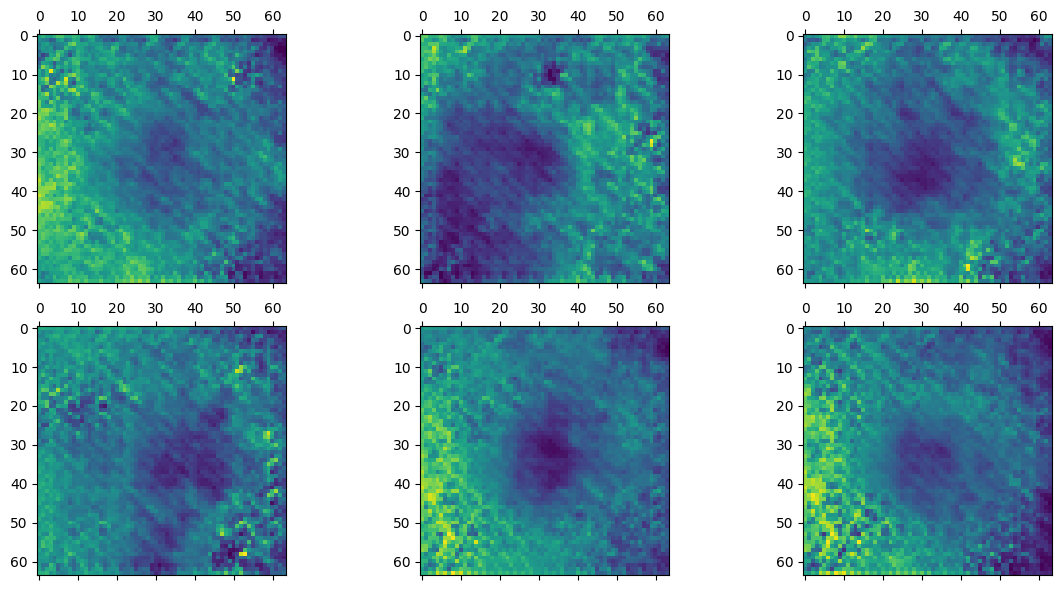

Epoch number:  500
*** Training ***
Discriminator Loss  0.6259706020355225
Generator Loss:  0.788314700126648
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6399999856948853
Discriminator Accuracy on FAKE (generated) images:  0.6200000047683716


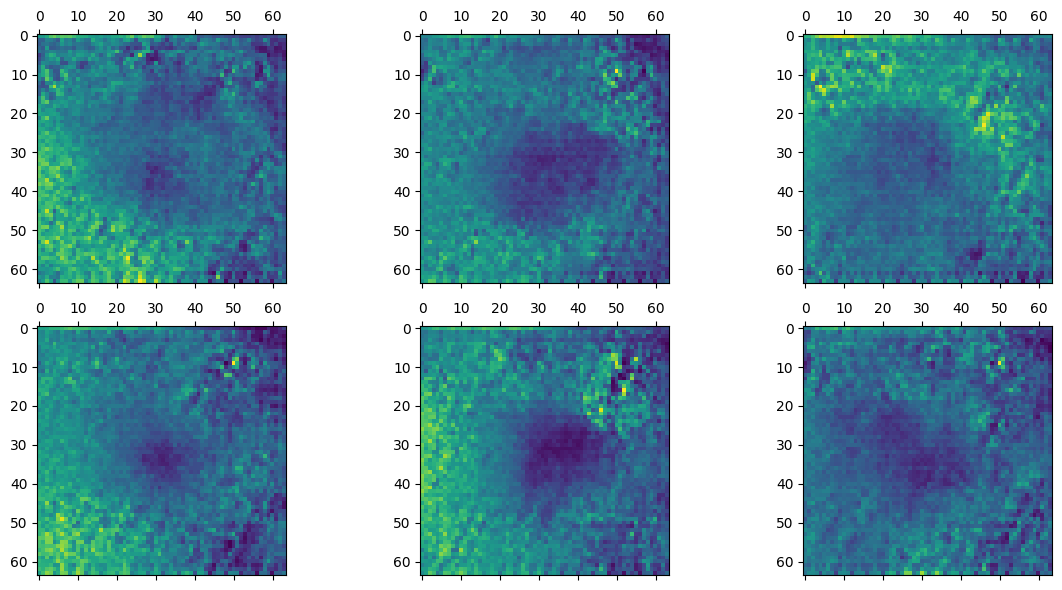

Epoch number:  600
*** Training ***
Discriminator Loss  0.6294391751289368
Generator Loss:  0.9504842758178711
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.41999998688697815
Discriminator Accuracy on FAKE (generated) images:  0.9200000166893005


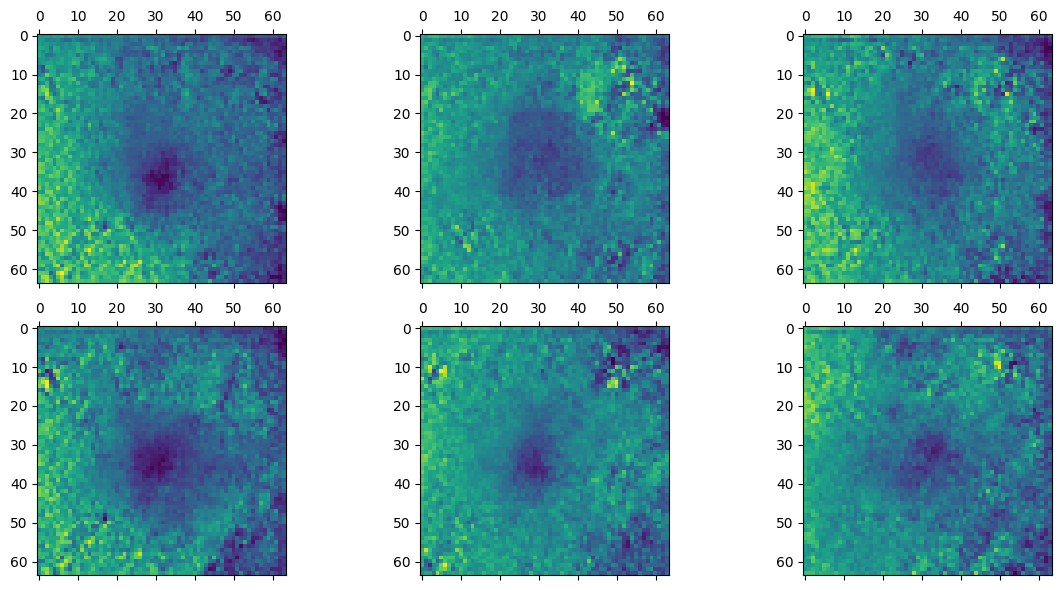

Epoch number:  700
*** Training ***
Discriminator Loss  0.6488767266273499
Generator Loss:  0.9373238682746887
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6399999856948853
Discriminator Accuracy on FAKE (generated) images:  0.9800000190734863


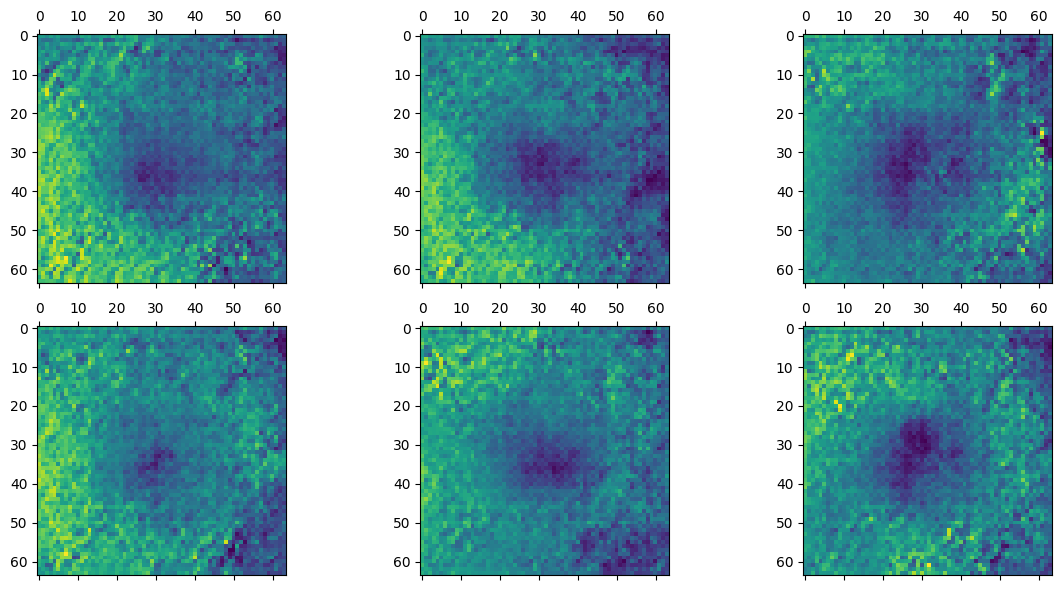

Epoch number:  800
*** Training ***
Discriminator Loss  0.5686242580413818
Generator Loss:  0.7902179956436157
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8999999761581421
Discriminator Accuracy on FAKE (generated) images:  0.6000000238418579


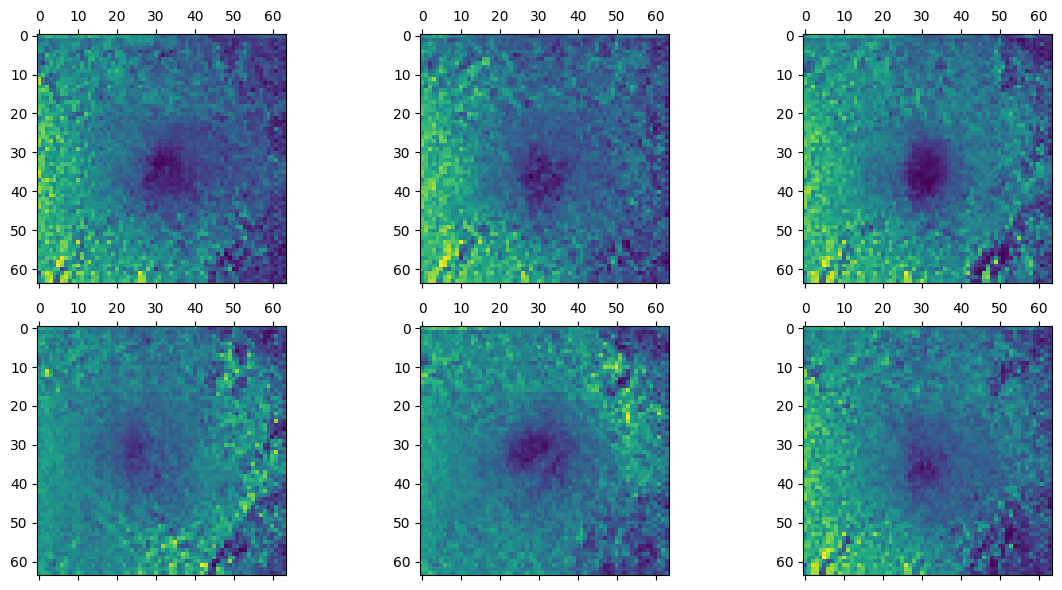

Epoch number:  900
*** Training ***
Discriminator Loss  0.6501040458679199
Generator Loss:  0.8419185876846313
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5400000214576721
Discriminator Accuracy on FAKE (generated) images:  0.7200000286102295


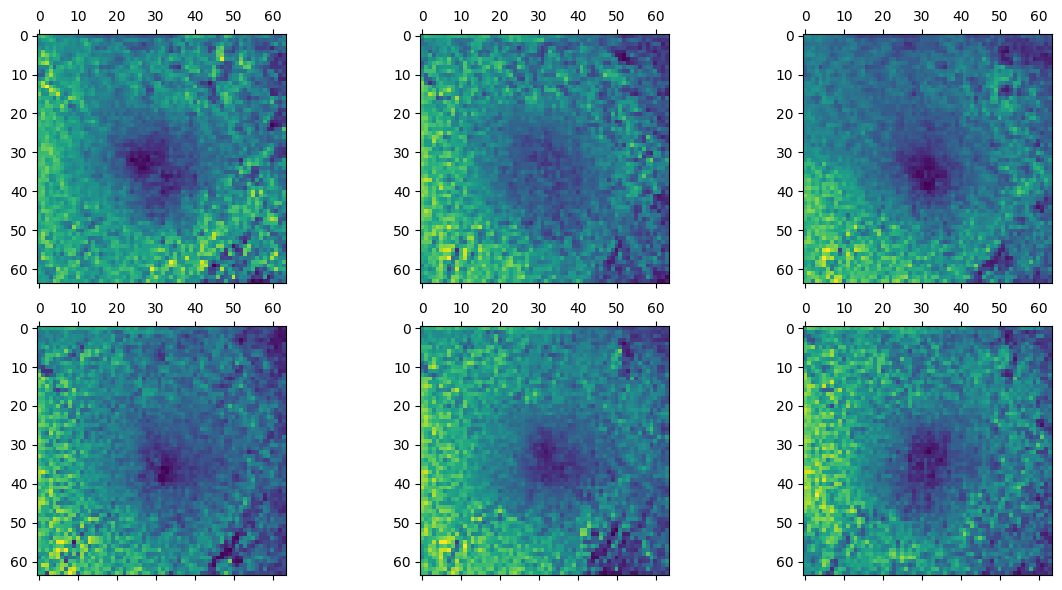

Epoch number:  1000
*** Training ***
Discriminator Loss  0.5685788989067078
Generator Loss:  0.8320956230163574
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7599999904632568
Discriminator Accuracy on FAKE (generated) images:  0.8199999928474426


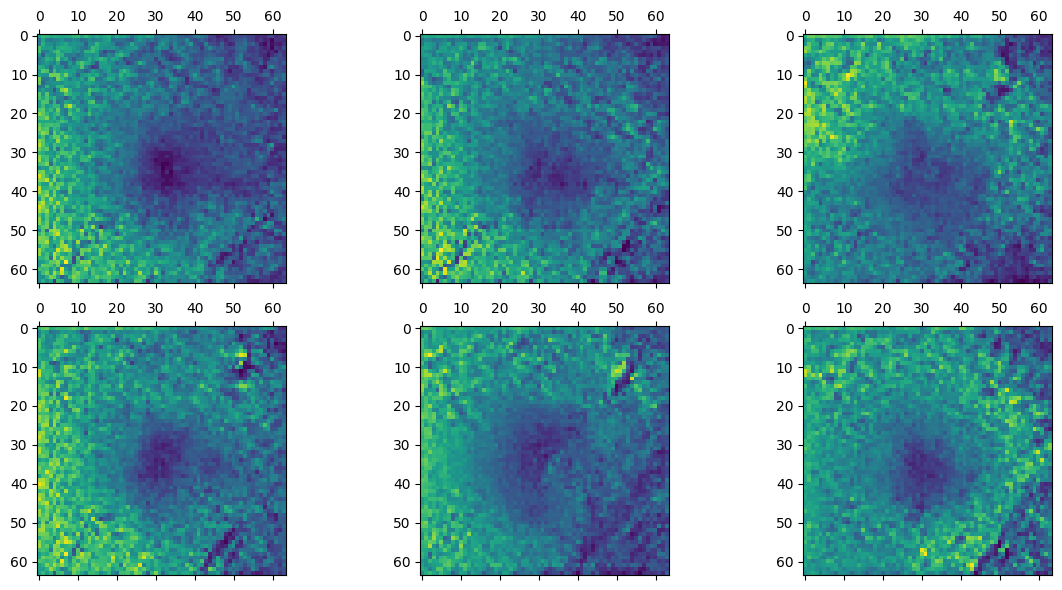

In [ ]:
# print(dataset.shape)
train(gen_model, dis_model, gan_model, data, latent_dim)

Epoch number:  0
*** Training ***
Discriminator Loss  0.6219016313552856
Generator Loss:  0.9071254730224609
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6800000071525574
Discriminator Accuracy on FAKE (generated) images:  0.8600000143051147


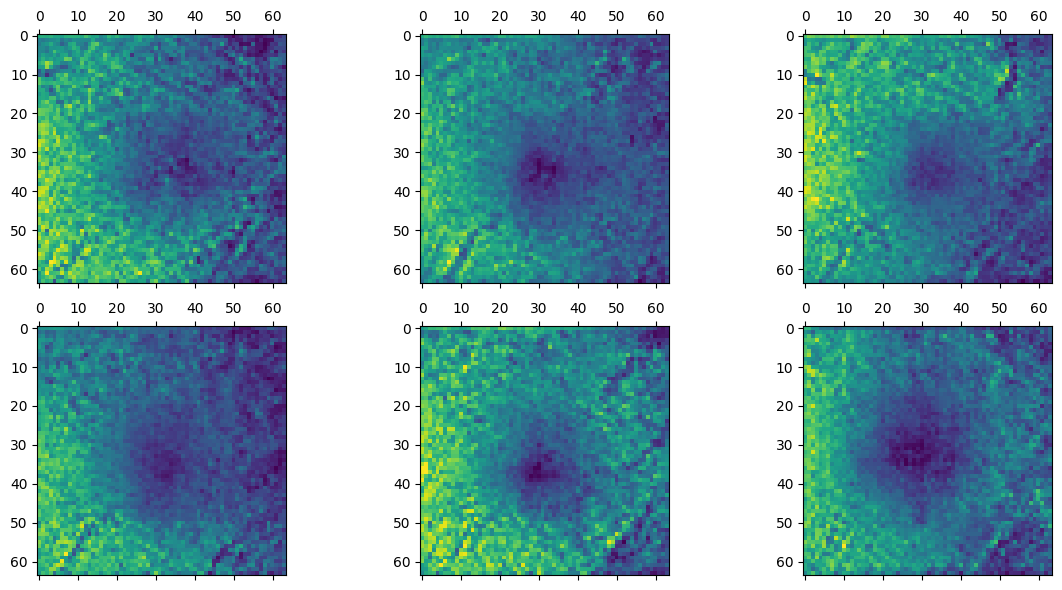

Epoch number:  100
*** Training ***
Discriminator Loss  0.561318576335907
Generator Loss:  1.0303292274475098
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6200000047683716
Discriminator Accuracy on FAKE (generated) images:  0.7799999713897705


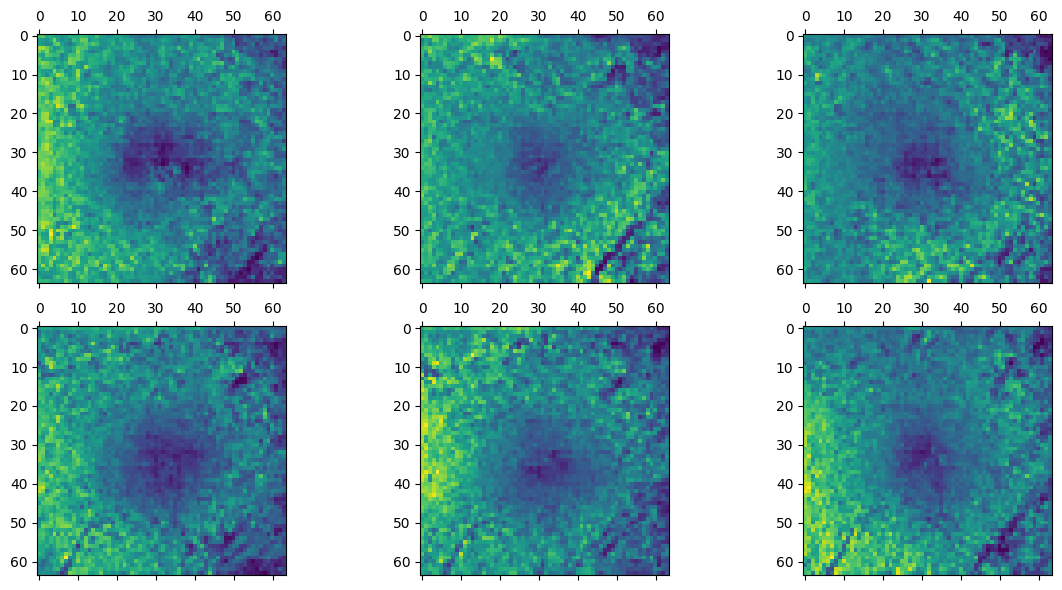

Epoch number:  200
*** Training ***
Discriminator Loss  0.5232204794883728
Generator Loss:  1.0290054082870483
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.4399999976158142
Discriminator Accuracy on FAKE (generated) images:  0.9399999976158142


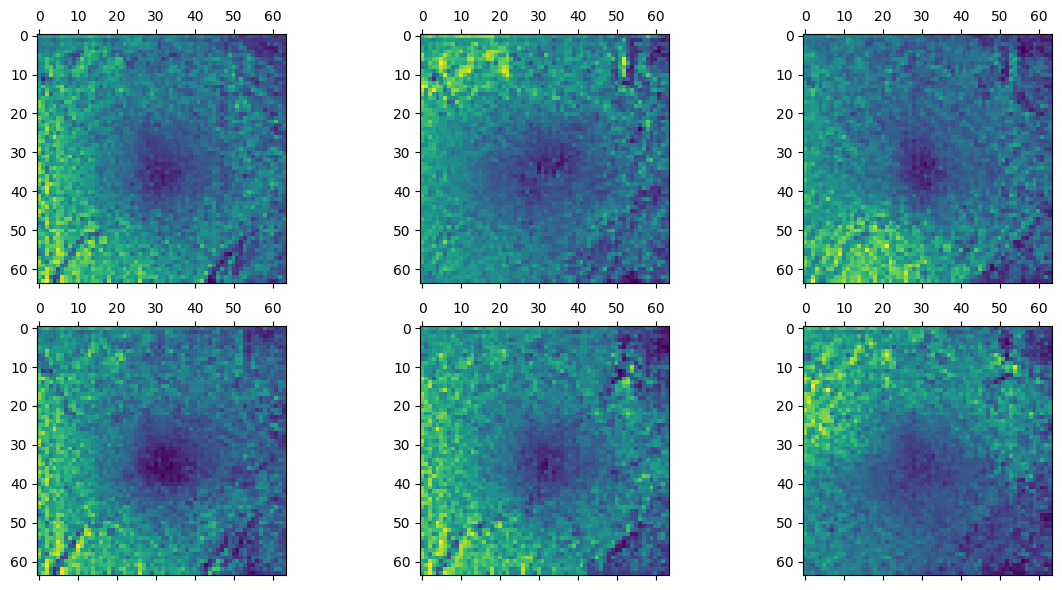

Epoch number:  300
*** Training ***
Discriminator Loss  0.557978093624115
Generator Loss:  0.9941951632499695
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8799999952316284
Discriminator Accuracy on FAKE (generated) images:  0.7400000095367432


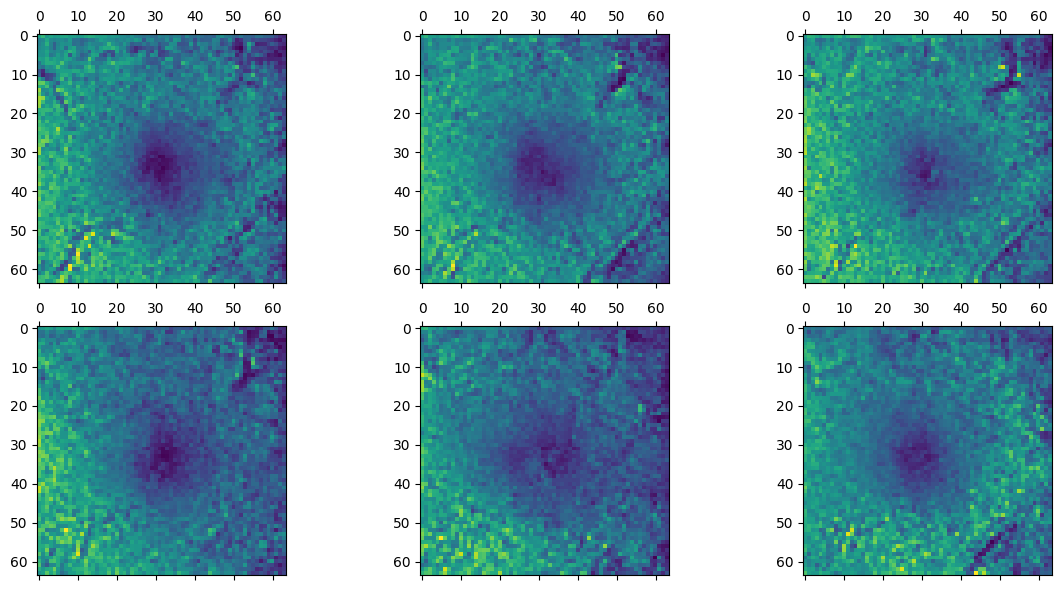

Epoch number:  400
*** Training ***
Discriminator Loss  0.4848320484161377
Generator Loss:  1.3691879510879517
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5799999833106995
Discriminator Accuracy on FAKE (generated) images:  1.0


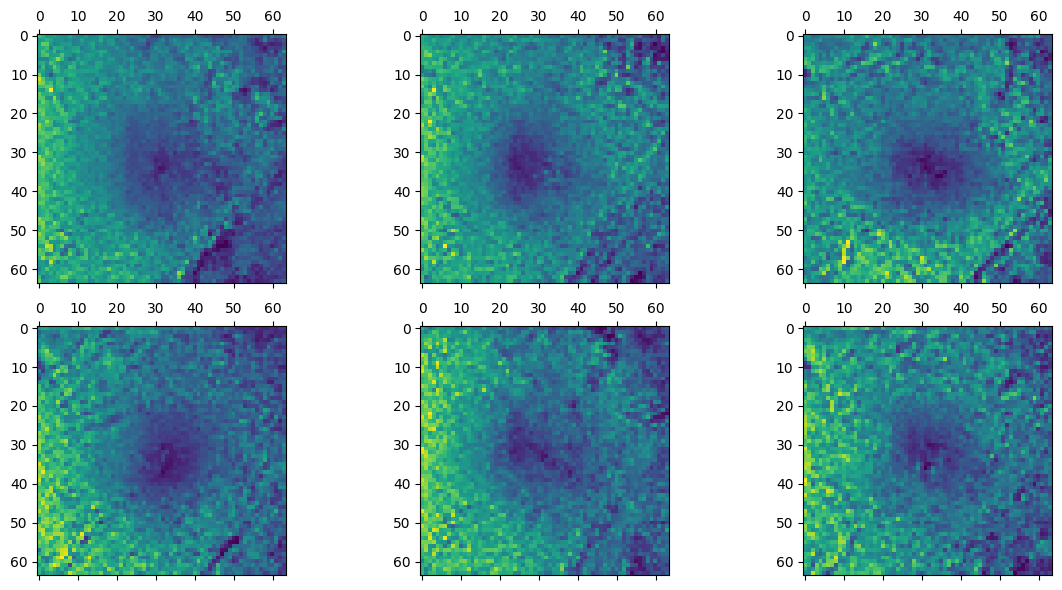

Epoch number:  500
*** Training ***
Discriminator Loss  0.5443242192268372
Generator Loss:  0.9265758991241455
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9399999976158142
Discriminator Accuracy on FAKE (generated) images:  0.6600000262260437


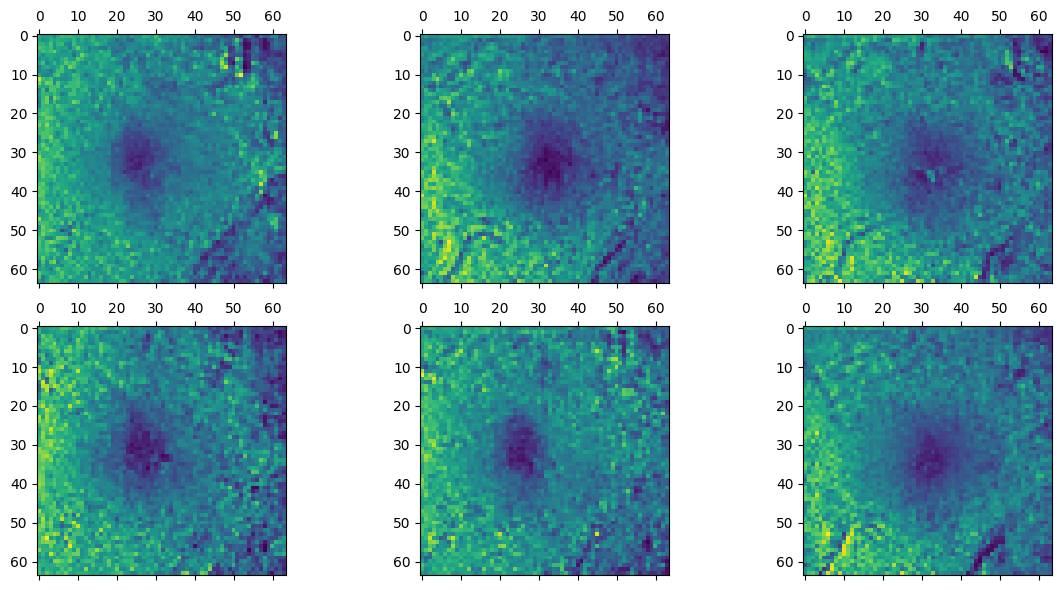

Epoch number:  600
*** Training ***
Discriminator Loss  0.5835168361663818
Generator Loss:  1.1648454666137695
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8600000143051147
Discriminator Accuracy on FAKE (generated) images:  0.9399999976158142


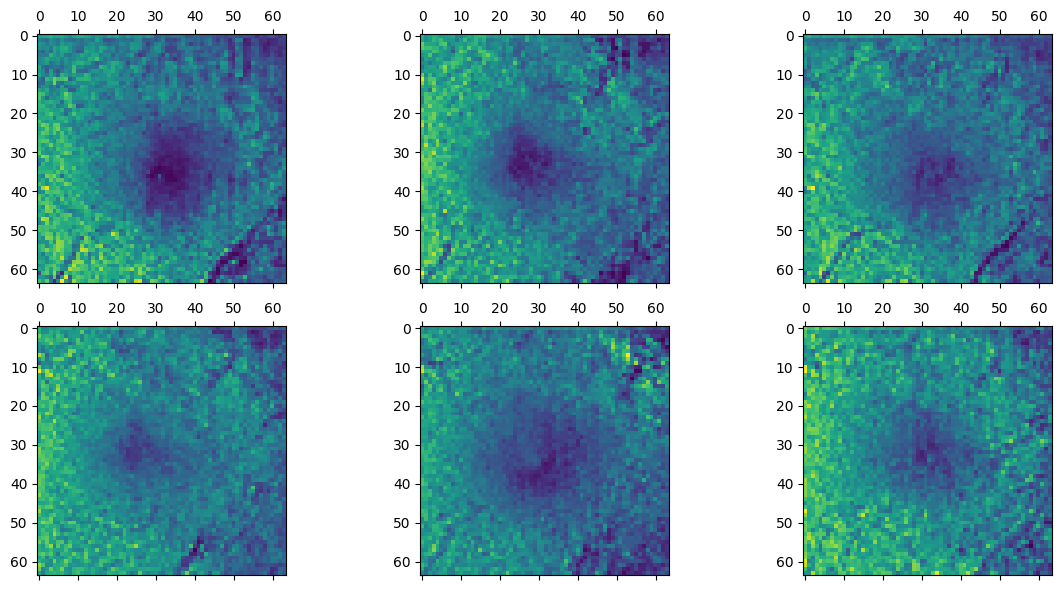

Epoch number:  700
*** Training ***
Discriminator Loss  0.5536930561065674
Generator Loss:  1.028022289276123
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8199999928474426
Discriminator Accuracy on FAKE (generated) images:  0.8399999737739563


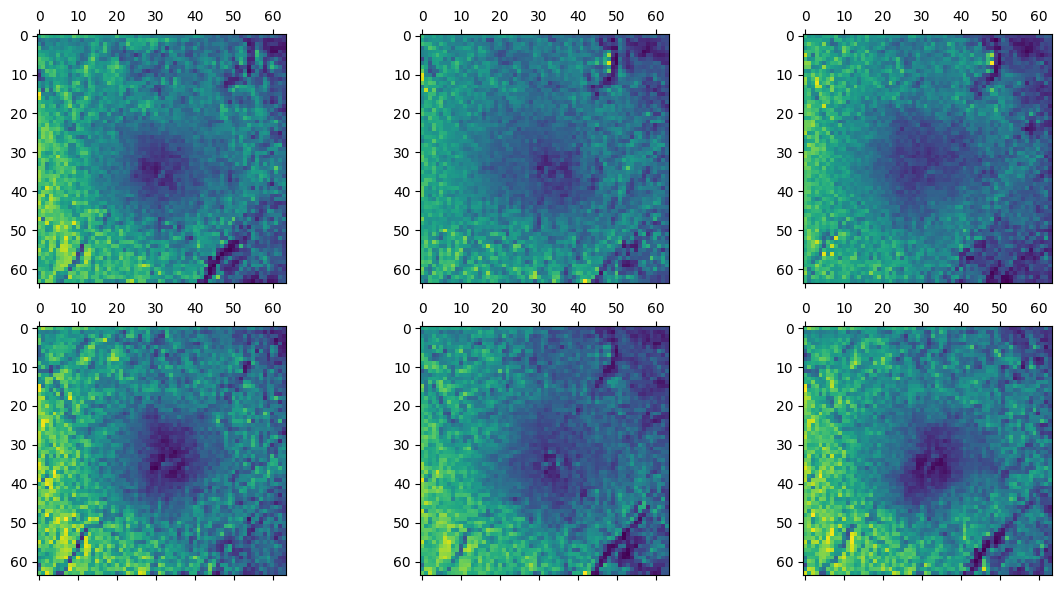

Epoch number:  800
*** Training ***
Discriminator Loss  0.48199623823165894
Generator Loss:  1.2700942754745483
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6600000262260437
Discriminator Accuracy on FAKE (generated) images:  0.9399999976158142


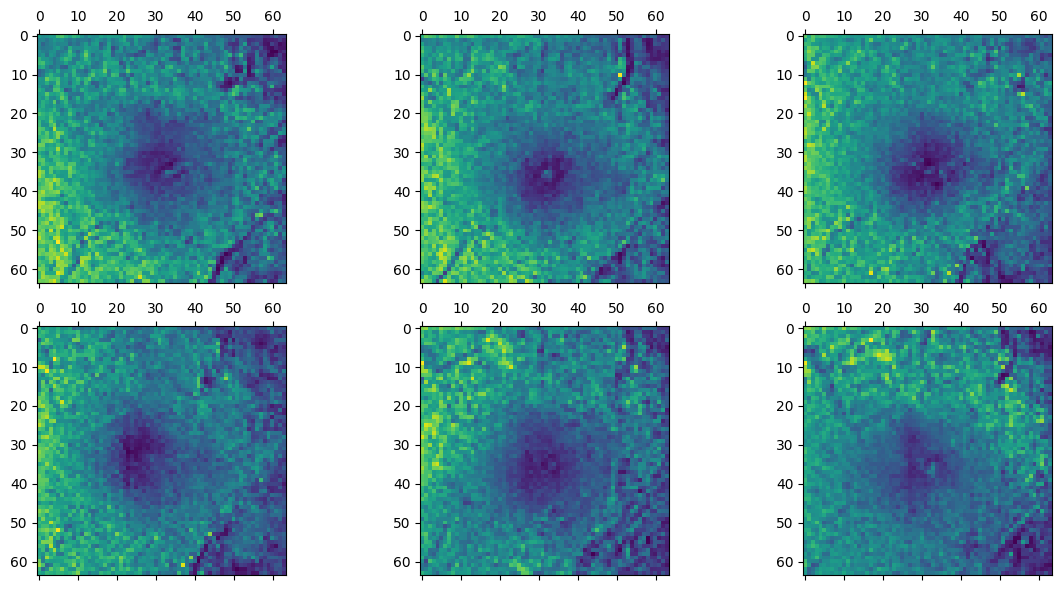

Epoch number:  900
*** Training ***
Discriminator Loss  0.48870086669921875
Generator Loss:  1.1397650241851807
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.800000011920929
Discriminator Accuracy on FAKE (generated) images:  0.9399999976158142


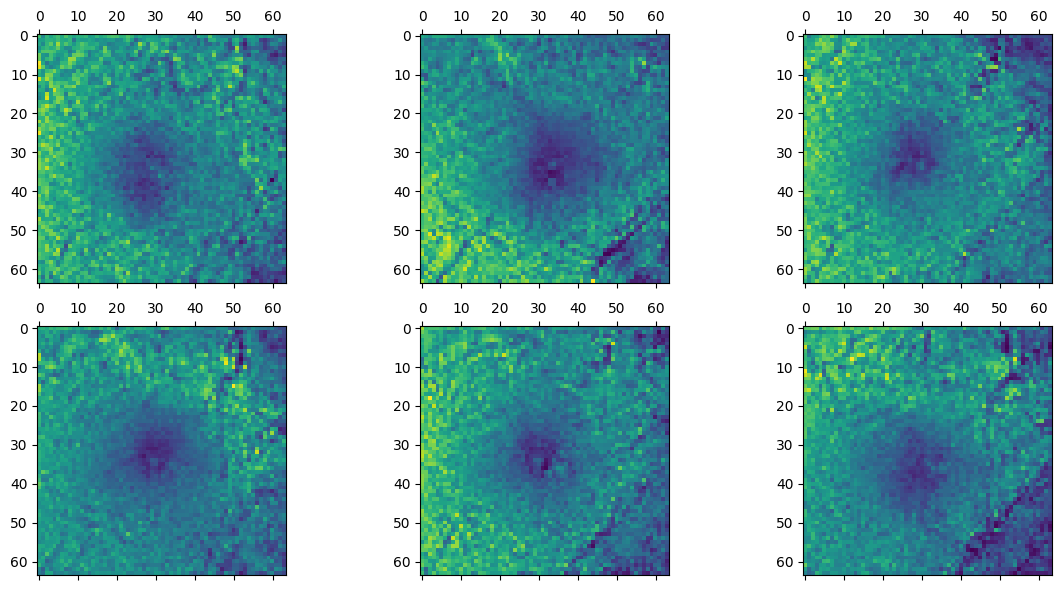

Epoch number:  1000
*** Training ***
Discriminator Loss  0.4197973906993866
Generator Loss:  1.2058202028274536
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6200000047683716
Discriminator Accuracy on FAKE (generated) images:  0.9200000166893005


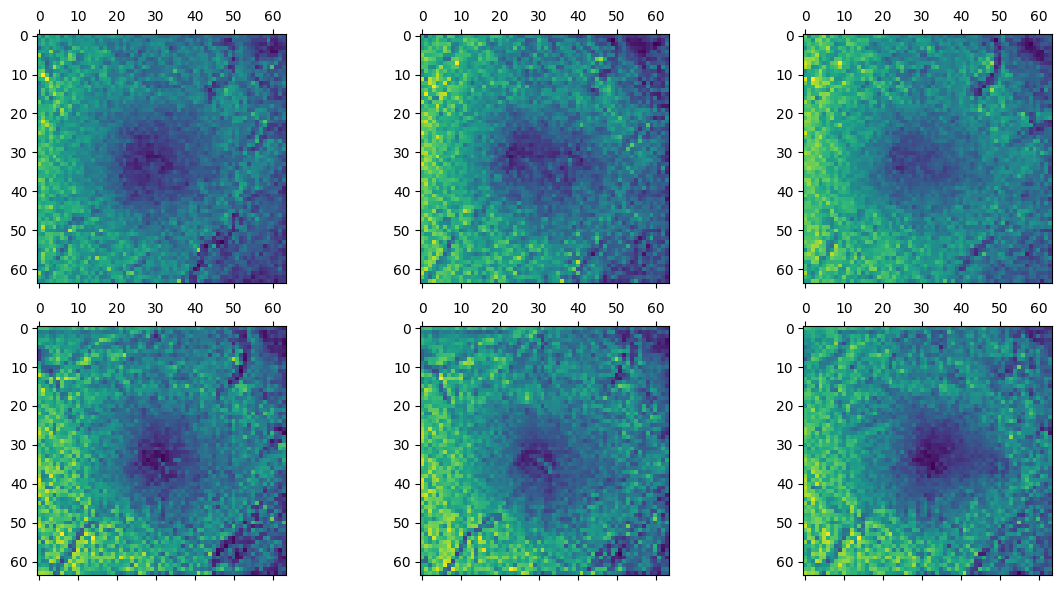

In [ ]:
train(gen_model, dis_model, gan_model, data, latent_dim)

Epoch number:  0
*** Training ***
Discriminator Loss  0.5493180155754089
Generator Loss:  0.9668234586715698
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6800000071525574
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


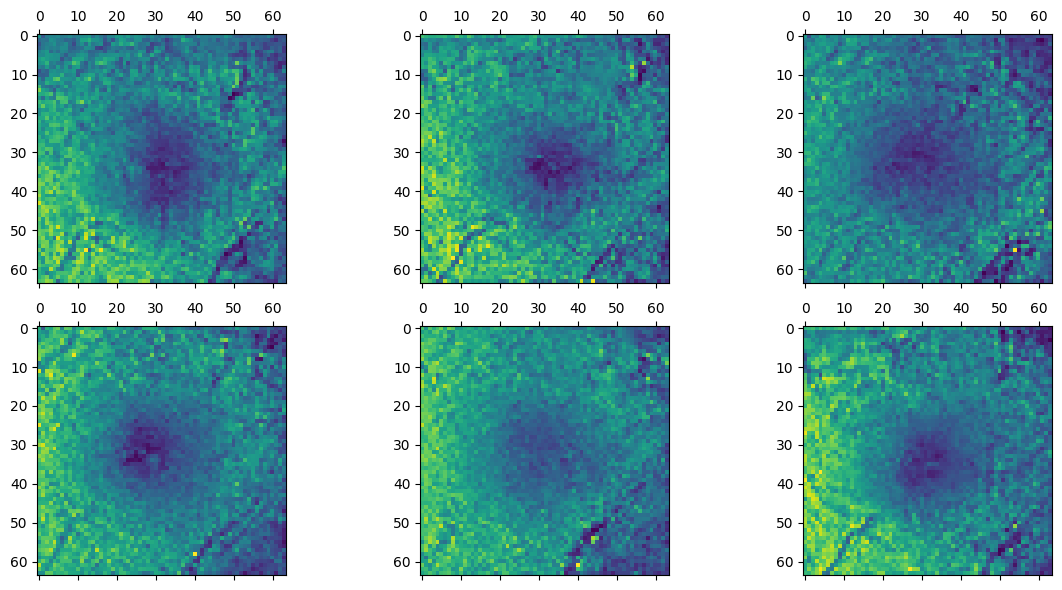

Epoch number:  100
*** Training ***
Discriminator Loss  0.4646593928337097
Generator Loss:  1.267209529876709
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6800000071525574
Discriminator Accuracy on FAKE (generated) images:  1.0


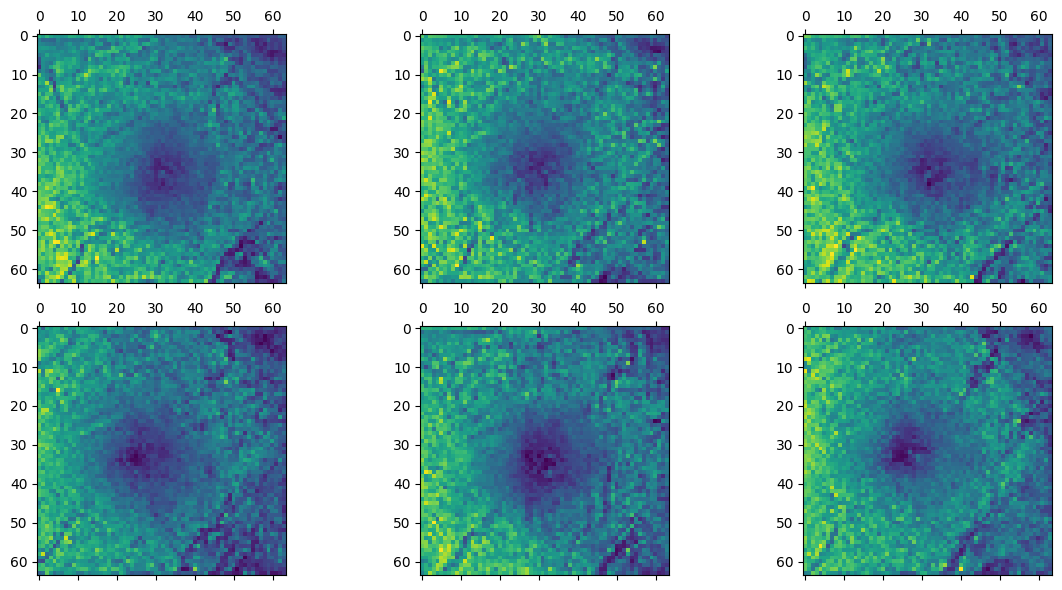

Epoch number:  200
*** Training ***
Discriminator Loss  0.5101079344749451
Generator Loss:  1.0247998237609863
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9399999976158142
Discriminator Accuracy on FAKE (generated) images:  0.8799999952316284


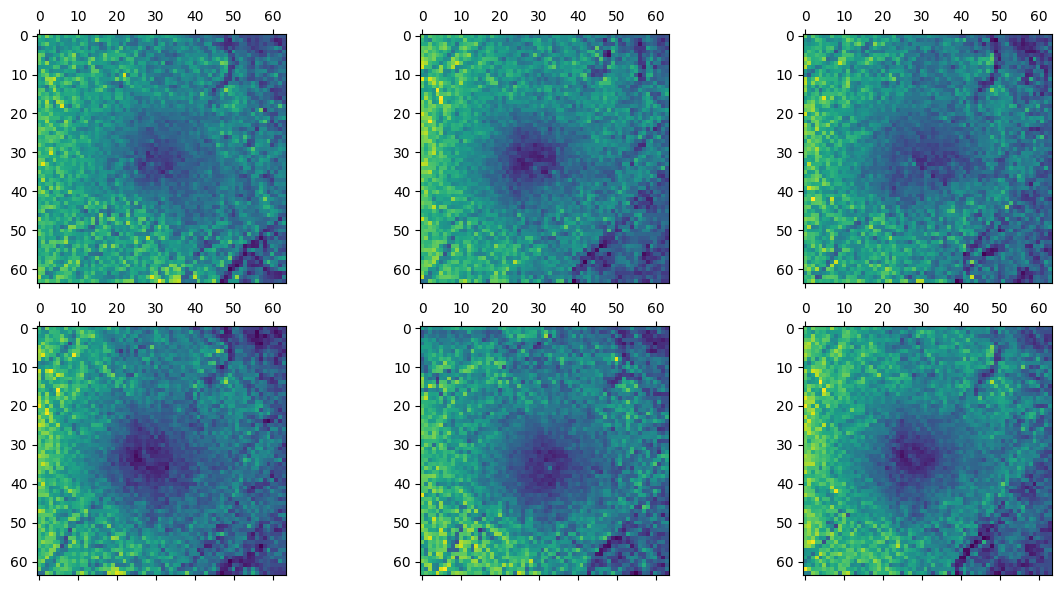

Epoch number:  300
*** Training ***
Discriminator Loss  0.4553881287574768
Generator Loss:  1.2045085430145264
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7400000095367432
Discriminator Accuracy on FAKE (generated) images:  0.8399999737739563


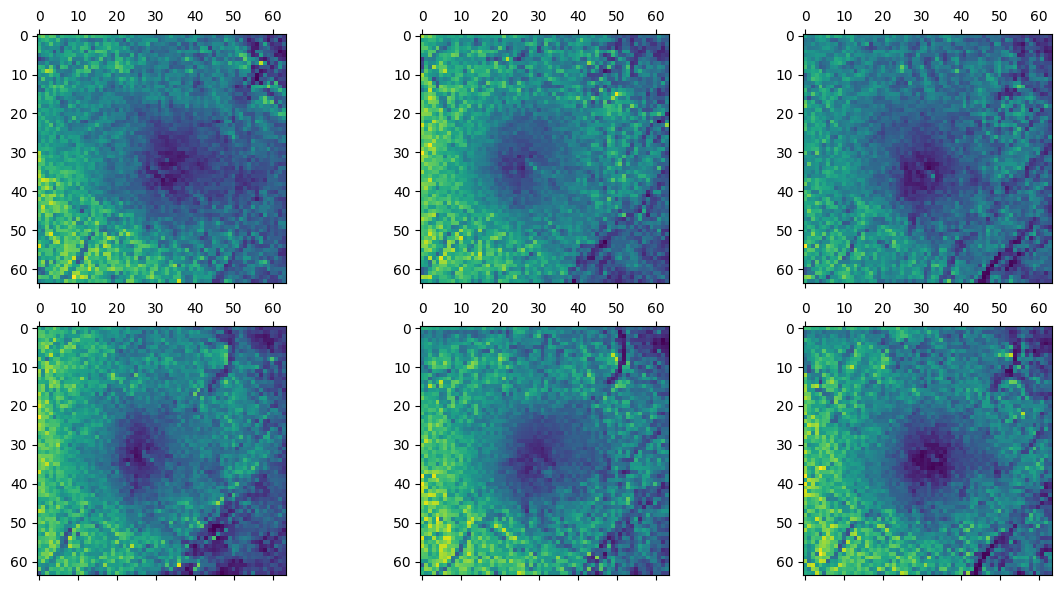

Epoch number:  400
*** Training ***
Discriminator Loss  0.43616241216659546
Generator Loss:  1.444760799407959
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7599999904632568
Discriminator Accuracy on FAKE (generated) images:  0.9800000190734863


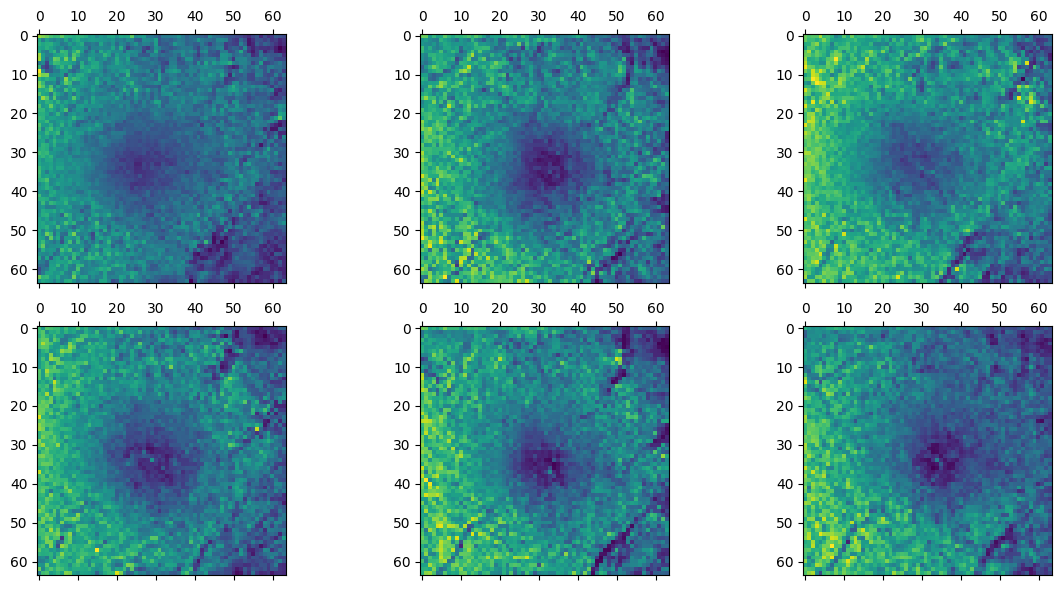

Epoch number:  500
*** Training ***
Discriminator Loss  0.4298589527606964
Generator Loss:  1.1838802099227905
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7200000286102295
Discriminator Accuracy on FAKE (generated) images:  0.8399999737739563


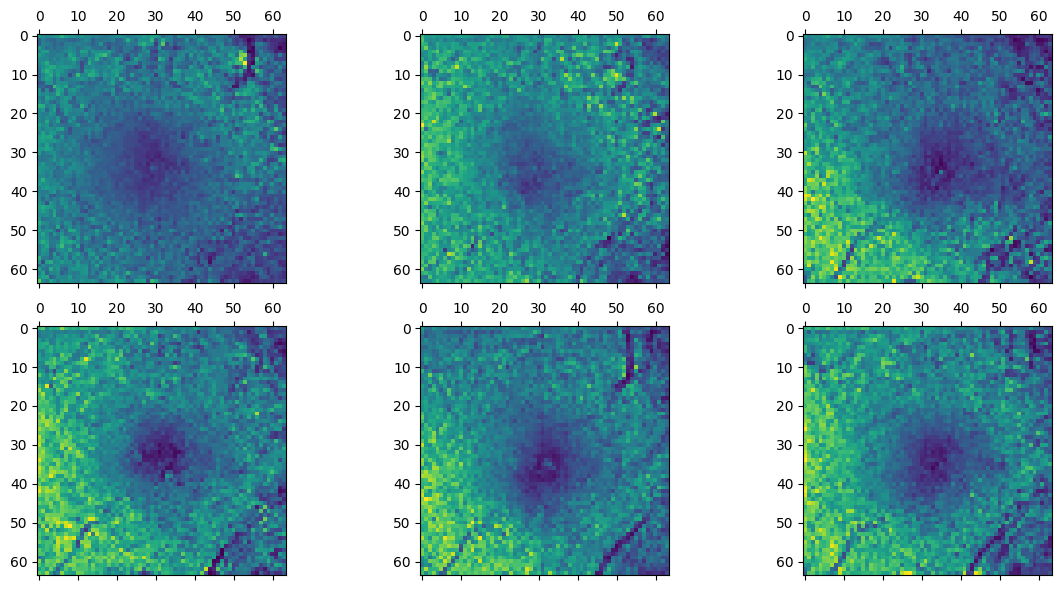

Epoch number:  600
*** Training ***
Discriminator Loss  0.5267955660820007
Generator Loss:  1.259145736694336
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8399999737739563
Discriminator Accuracy on FAKE (generated) images:  0.8999999761581421


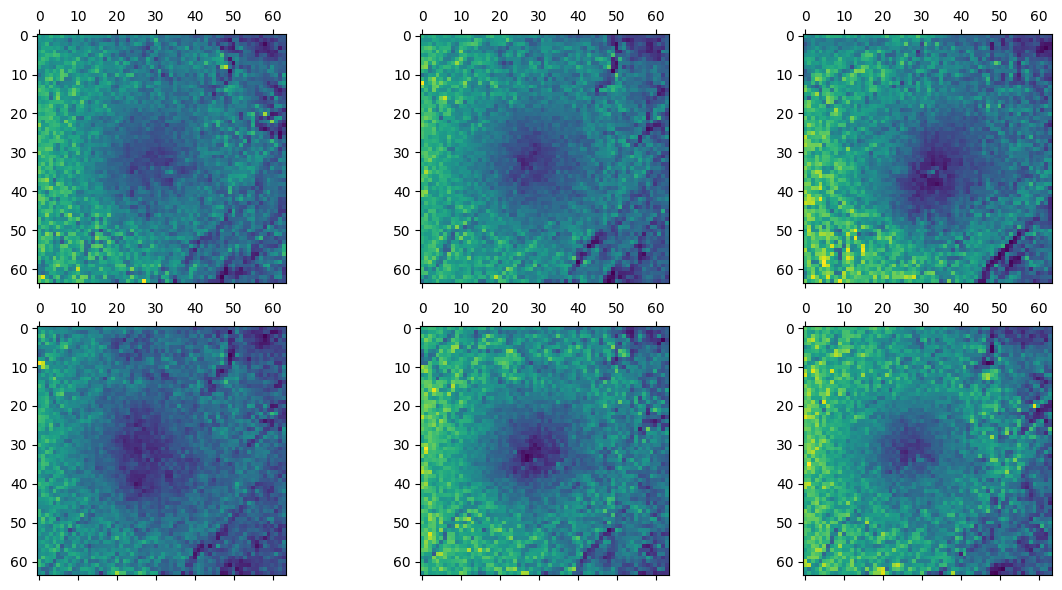

Epoch number:  700
*** Training ***
Discriminator Loss  0.4484283924102783
Generator Loss:  0.9816302061080933
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8799999952316284
Discriminator Accuracy on FAKE (generated) images:  0.8399999737739563


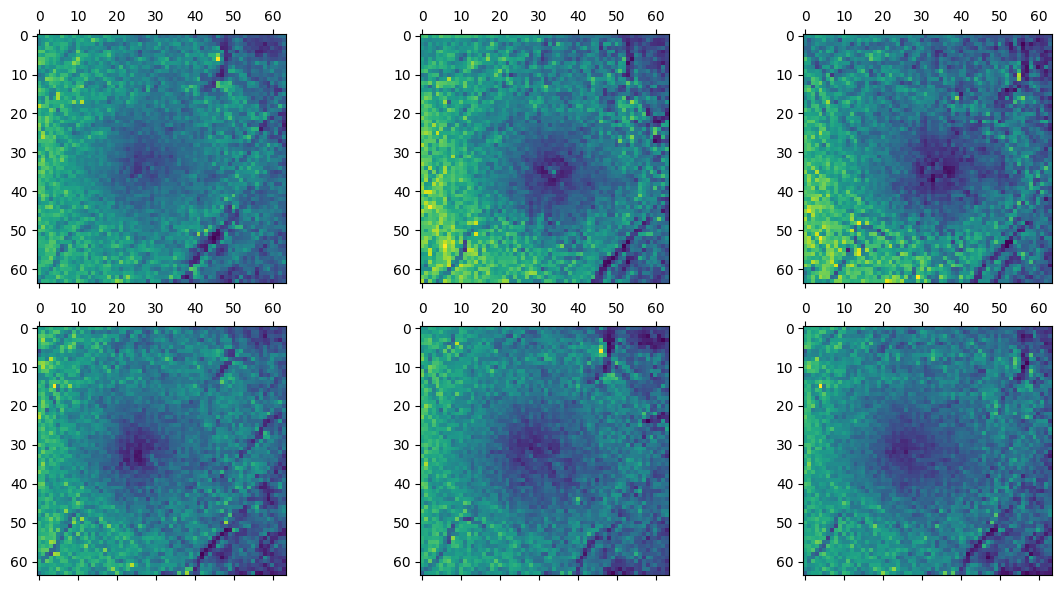

Epoch number:  800
*** Training ***
Discriminator Loss  0.4655952751636505
Generator Loss:  1.3800151348114014
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.699999988079071
Discriminator Accuracy on FAKE (generated) images:  1.0


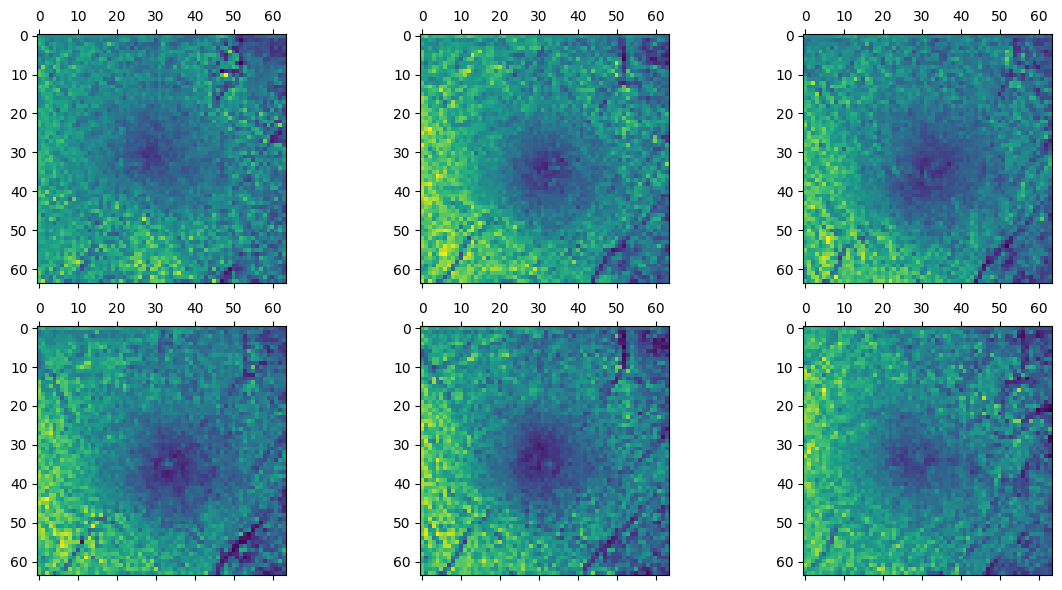

Epoch number:  900
*** Training ***
Discriminator Loss  0.41075599193573
Generator Loss:  1.19035005569458
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9200000166893005
Discriminator Accuracy on FAKE (generated) images:  1.0


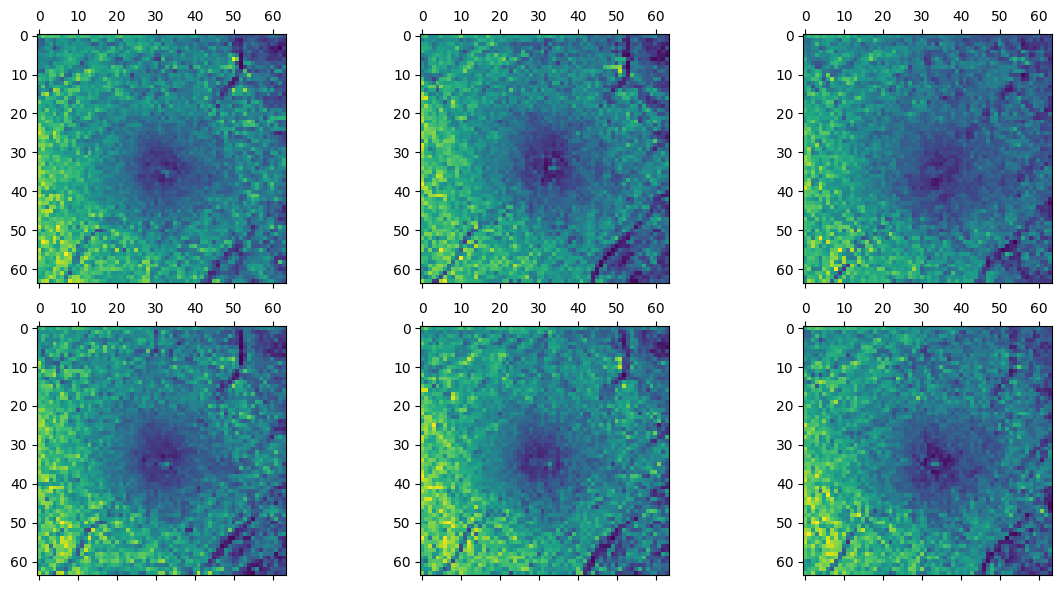

Epoch number:  1000
*** Training ***
Discriminator Loss  0.4436405301094055
Generator Loss:  1.680700421333313
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6200000047683716
Discriminator Accuracy on FAKE (generated) images:  0.9800000190734863


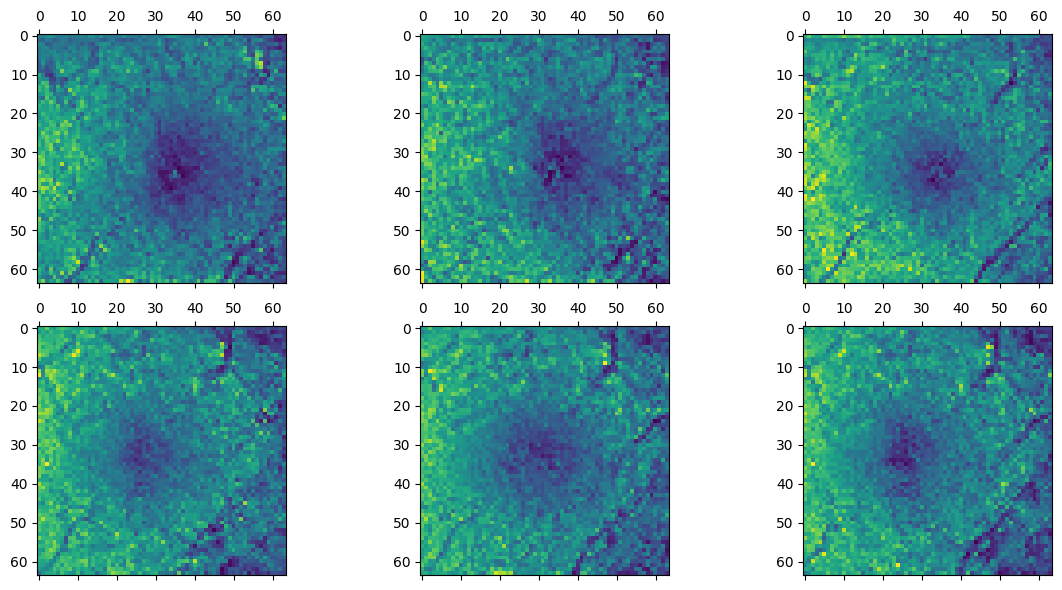

In [ ]:
train(gen_model, dis_model, gan_model, data, latent_dim)

In [70]:
# Generate an image of a bonsai tree using random latent vector
x_fake, y_fake = fake_samples(gen_model, 100, 1)

# Shape and inverse transpose the generated image
x_fake_inv_trans=x_fake.reshape(-1, 1)
x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
x_fake_inv_trans=x_fake_inv_trans.reshape(64, 64, 1)

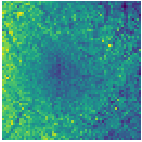

In [76]:
# Show the generated image
fig, ax = plt.subplots(figsize=(16,9), dpi=20)
ax.matshow(x_fake_inv_trans)
plt.axis('off')
plt.show()

In [78]:
print(x_fake_inv_trans.shape)

(64, 64, 1)


In [81]:
all_frames = []

tot_frames = 3000
for i in range(tot_frames):
  x_fake, y_fake = fake_samples(gen_model, 100, 1)
  x_fake_inv_trans=x_fake.reshape(-1, 1)
  x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
  x_fake_inv_trans=x_fake_inv_trans.reshape(64, 64, 1)

  all_frames.append(x_fake_inv_trans)

  if i % 100 == 0:
    print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [87]:
import cv2
import numpy as np

def create_video(image_list, output_file='output.avi', fps=30):
    """
    Creates a video from a list of grayscale images (numpy arrays).

    :param image_list: List of numpy arrays, each representing a grayscale image.
    :param output_file: Name of the output video file.
    :param fps: Frames per second of the output video.
    """
    # Check the shape of the first image to determine if it's 2D or 3D
    if len(image_list[0].shape) == 3:
        height, width, _ = image_list[0].shape
    else:  # It's a 2D image
        height, width = image_list[0].shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height), False)

    for img in image_list:
        if img.dtype != np.uint8:
            # Normalize and convert to uint8
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        if len(img.shape) == 3 and img.shape[2] == 1:  # If the image is 3D but has only one channel
            img = img.reshape((height, width))  # Convert it to 2D

        if img.ndim == 2:  # If the image is 2D
            img = np.stack((img,)*3, axis=-1)  # Convert to 3-channel image

        out.write(img)

    # Release everything when job is finished
    out.release()

# Example usage
# Assuming you have a list of numpy arrays named 'all_frames'
# create_video(all_frames)


In [88]:
create_video(all_frames)